# Comparison metrics

Because we cannot trust the human eyes to make comparison between pictures, especially if the eye is French and colorblind.

## Requirements

In [7]:
import os
import sys
import json
import random
from pathlib import Path
sys.path.insert(0, os.path.join("..", "..", "src"))


import torch
import pyvips
import deeplake
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

%pip install piq
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse
from sklearn.metrics import mutual_info_score
from skimage import io, color, filters
from scipy.stats import pearsonr
from scipy.spatial.distance import cosine
import cv2
import seaborn as sns
from piq import multi_scale_ssim, gmsd, gradient_magnitude


/home/leolr-int/miniforge3/envs/py312/lib/python3.12/site-packages/deeplake/__init__.py:322: UserWarning: Global variable 'KFBio_1' of type <class 'deeplake._deeplake.ReadOnlyDataset'> may cause issues when using fork-based multiprocessing. Consider avoiding global variables of this type, or pass to subprocess as an agrument or by manual pickling.
  warnings.warn(


Note: you may need to restart the kernel to use updated packages.


ImportError: cannot import name 'gradient_magnitude' from 'piq' (/home/leolr-int/miniforge3/envs/py312/lib/python3.12/site-packages/piq/__init__.py)

Functions to migrate image appearance

In [4]:
def low_freq_mutate_np( amp_src, amp_trg, L=0.1 ):
    a_src = np.fft.fftshift( amp_src, axes=(-2, -1) )
    a_trg = np.fft.fftshift( amp_trg, axes=(-2, -1) )

    _, h, w = a_src.shape
    b = (  np.floor(np.amin((h,w))*L)  ).astype(int)
    c_h = np.floor(h/2.0).astype(int)
    c_w = np.floor(w/2.0).astype(int)
    

    h1 = c_h-b
    h2 = c_h+b+1
    w1 = c_w-b
    w2 = c_w+b+1

    a_src[:,h1:h2,w1:w2] = a_trg[:,h1:h2,w1:w2]
    a_src = np.fft.ifftshift( a_src, axes=(-2, -1) )
    return a_src

def modif_FDA_source_to_target_np( src_img, amp_trg, L=0.1 ):
    fft_src_np = np.fft.fft2( src_img, axes=(-2, -1) )
    amp_src, pha_src = np.abs(fft_src_np), np.angle(fft_src_np)
    amp_src_ = low_freq_mutate_np( amp_src, amp_trg, L=L )
    fft_src_ = amp_src_ * np.exp( 1j * pha_src )
    src_in_trg = np.fft.ifft2( fft_src_, axes=(-2, -1) )
    src_in_trg = np.real(src_in_trg)

    return src_in_trg

def image_to_label(src_img, label, L_hyperparam=0.1):
    # computes the transformation of KBio images to the label-based amplitude
    trg_amp = np.load(f"/home/leolr-int/ASTAR_internship/Fourier_Domain_Adaptation/stored_amplitude/label_based_average/average_label_{label}_akoya.npy")
    return modif_FDA_source_to_target_np( src_img, trg_amp, L=L_hyperparam)

In [ ]:
def load_and_preprocess_image(img_array):
    """Load image from numpy array and convert to appropriate format"""
    img = img_array.copy()

    # Convert to grayscale if needed for some metrics
    if len(img.shape) == 3:
        img_gray = color.rgb2gray(img)
    else:
        img_gray = img

    # Normalize to [0, 1] range
    if img.max() > 1:
        img = img.astype(np.float64) / 255.0
        img_gray = img_gray.astype(np.float64) / 255.0

    return img, img_gray

def compute_similarity_metrics(original, comparison, original_gray, comparison_gray):
    """Compute various similarity metrics between two images"""
    metrics = {}
    

    # 1. Structural Similarity Index (SSIM)
    metrics['SSIM'] = ssim(original_gray, comparison_gray, data_range=1.0)
    print(f"SSIM: {metrics['SSIM']:.4f}")

    # 2. Peak Signal-to-Noise Ratio (PSNR)
    metrics['PSNR'] = psnr(original, comparison, data_range=1.0)

    # 3. Root Mean Squared Error (RMSE) to show color deviations
    metrics['MSE'] = mse(original, comparison)
    metrics['RMSE'] = np.sqrt(metrics['MSE'])

    # 4. Normalized Cross-Correlation (NCC)
    original_flat = original_gray.flatten()
    comparison_flat = comparison_gray.flatten()
    correlation, _ = pearsonr(original_flat, comparison_flat)
    metrics['Correlation'] = correlation

    # 5. Cosine Similarity
    metrics['Cosine_Similarity'] = 1 - cosine(original_flat, comparison_flat)

    # 6. Histogram Intersection (for color images)
    if len(original.shape) == 3:
        original_uint8 = (original * 255).astype(np.uint8)
        comparison_uint8 = (comparison * 255).astype(np.uint8)
        hist_orig = cv2.calcHist([original_uint8], [0, 1, 2], None, [50, 50, 50], [0, 256, 0, 256, 0, 256])
        hist_comp = cv2.calcHist([comparison_uint8], [0, 1, 2], None, [50, 50, 50], [0, 256, 0, 256, 0, 256])
        metrics['Histogram_Intersection'] = cv2.compareHist(hist_orig, hist_comp, cv2.HISTCMP_INTERSECT)

    # 7. Edge-based similarity using Sobel filters (applied on gray sclae)
    edges_orig = filters.sobel(original_gray)
    edges_comp = filters.sobel(comparison_gray)
    edge_similarity = ssim(edges_orig, edges_comp, data_range=edges_orig.max() - edges_orig.min())
    metrics['Edge_SSIM'] = edge_similarity

    # 8. Edge-based similarity using Gradient Magnitude Similarity Deviation (applied on colors)
    # computed across all channels and then it is averaged
    original = original.astype(np.float32)
    comparison = comparison.astype(np.float32)
    original = np.clip(original, 0.0, 1.0) #because some pixel are above 255
    comparison = np.clip(comparison, 0.0, 1.0)

    # Convert to PyTorch tensor with shape [1, 3, H, W] (adds batch size)
    original_tensor = torch.from_numpy(original).permute(2, 0, 1).unsqueeze(0)
    comparison_tensor = torch.from_numpy(comparison).permute(2, 0, 1).unsqueeze(0)

    # Compute GMSD per channel
    gmsd_values = []
    for c in range(3):
        gmsd_c = gmsd(original_tensor[:, c:c+1], comparison_tensor[:, c:c+1], data_range=1.0)
        gmsd_values.append(gmsd_c.item())

    metrics["GMSD"] = np.mean(gmsd_values)

    return metrics

def create_difference_visualizations(original, comparison, original_gray, comparison_gray, title):
    """Create various difference visualizations"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'Difference Analysis: {title}', fontsize=16)

    # 1. Original image
    axes[0, 0].imshow(original, cmap='gray' if len(original.shape) == 2 else None)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')

    # 2. Comparison image
    axes[0, 1].imshow(comparison, cmap='gray' if len(comparison.shape) == 2 else None)
    axes[0, 1].set_title('Comparison Image')
    axes[0, 1].axis('off')

    # 3. Difference histogram
    diff_flat = (original_gray - comparison_gray).flatten()
    axes[0, 2].hist(diff_flat, bins=50, alpha=0.7, color='blue')
    axes[0, 2].set_title('Difference Histogram')
    axes[0, 2].set_xlabel('Pixel Difference')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Euclidian distance
    sq_diff = (original_gray - comparison_gray) ** 2
    im2 = axes[1, 0].imshow(sq_diff, cmap='hot')
    axes[1, 0].set_title('Squared Difference')
    axes[1, 0].axis('off')
    plt.colorbar(im2, ax=axes[1, 0])

    # 5. Gradient magnitude
    def compute_gradient_magnitude(image):
        """
        Compute gradient magnitude for each channel of a [H, W, 3] image.
        Returns array of shape [3, H, W].
        """
        grad_mag = []
        for c in range(3):
            gx = filters.sobel(image[:, :, c], axis=1)
            gy = filters.sobel(image[:, :, c], axis=0)
            mag = np.sqrt(gx**2 + gy**2)
            grad_mag.append(mag)
        return np.stack(grad_mag)  # Shape: (3, H, W)

    # Assume original and comparison are [H, W, 3], in [0, 1]
    grad_orig = compute_gradient_magnitude(original)
    grad_comp = compute_gradient_magnitude(comparison)

    # Compute absolute difference and average over channels
    grad_diff_map = np.abs(grad_orig - grad_comp).mean(axis=0)  # Shape: (H, W)

    # Plot the gradient difference heatmap
    im_grad = axes[1, 1].imshow(grad_diff_map, cmap='inferno')
    axes[1, 1].set_title('Gradient Magnitude Difference (RGB avg)')
    axes[1, 1].axis('off')
    plt.colorbar(im_grad, ax=axes[1, 1])

    # SSIM map
    ssim_map = ssim(original_gray, comparison_gray, data_range=1.0, full=True)[1]
    im3 = axes[1, 2].imshow(ssim_map, cmap='RdYlBu')
    axes[1, 2].set_title('SSIM Map')
    axes[1, 2].axis('off')
    plt.colorbar(im3, ax=axes[1, 2])

    plt.tight_layout()
    return fig

def analyze_images(original, comparison_paths, save_results=True):
    """Main function to analyze image similarities"""

    # Load original image
    original, original_gray = load_and_preprocess_image(original)
    print(f"Original image shape: {original.shape}")

    # Store all results
    all_metrics = {}

    # Compare each image with the original
    for i, comp_path in enumerate(comparison_paths):
        print(f"\nProcessing comparison image {i+1}")

        # Load comparison image
        comparison, comparison_gray = load_and_preprocess_image(comp_path)

        # Check if images have the same dimensions
        if original.shape != comparison.shape:
            print(f"Warning: Shape mismatch. Original: {original.shape}, Comparison: {comparison.shape}")
            # Resize comparison to match original
            if len(comparison.shape) == 3:
                comparison = cv2.resize(comparison, (original.shape[1], original.shape[0]))
            comparison_gray = cv2.resize(comparison_gray, (original.shape[1], original.shape[0]))

        # Compute metrics
        metrics = compute_similarity_metrics(original, comparison, original_gray, comparison_gray)
        all_metrics[f'Image_{i+1}'] = metrics

        # Create visualizations
        fig = create_difference_visualizations(original, comparison, original_gray, comparison_gray, f'Image {i+1}')

        if save_results:
            fig.savefig(f'comparison_image_{i+1}.png', dpi=300, bbox_inches='tight')

        plt.show()

    # Create summary comparison
    create_summary_comparison(all_metrics, save_results)

    return all_metrics

def create_summary_comparison(all_metrics, save_results=True):
    """Create summary comparison of all metrics"""

    # Convert to DataFrame for easier plotting
    df = pd.DataFrame(all_metrics).T

    # Create summary plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Summary Comparison of All Images', fontsize=16)

    # SSIM comparison
    ssim_values = df['SSIM'].values*100
    print(f"SSIM values: {ssim_values}")
    axes[0, 0].bar(df.index, ssim_values, color='skyblue', alpha=0.7)
    axes[0, 0].set_title('Structural Similarity Index (SSIM) in %')
    axes[0, 0].set_ylabel('SSIM Value')
    axes[0, 0].set_ylim(0, max(ssim_values) + 0.05)
    axes[0, 0].grid(True, alpha=0.3)
    for i, v in enumerate(ssim_values):
        axes[0, 0].text(i, v + 0.01, f'{v:.6f}', ha='center', va='bottom')

    # PSNR comparison
    psnr_values = df['PSNR'].values
    axes[0, 1].bar(df.index, psnr_values, color='lightgreen', alpha=0.7)
    axes[0, 1].set_title('Peak Signal-to-Noise Ratio (PSNR)')
    axes[0, 1].set_ylabel('PSNR (dB)')
    axes[0, 1].set_ylim(0, max(psnr_values) + 3)
    axes[0, 1].grid(True, alpha=0.3)
    for i, v in enumerate(psnr_values):
        axes[0, 1].text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom')

    # Multiple metrics heatmap
    metrics_subset = ['SSIM', 'Correlation', 'Cosine_Similarity', 'PSNR', 'RMSE', 'Edge_SSIM', 'GMSD', 'Histogram_Intersection']
    df_subset = df[metrics_subset]

    # Normalize metrics for better visualization (0-1 scale)
    def normalize(series, maximize=True):
    min_val = series.min()
    max_val = series.max()
    if max_val - min_val == 0:
        return np.ones_like(series) if maximize else np.zeros_like(series)
    if maximize:
        return (series - min_val) / (max_val - min_val)
    else:
        return (max_val - series) / (max_val - min_val)

    df = df_subset.copy()
    df_norm = pd.DataFrame()
    df_norm["PSNR"] = normalize(df["PSNR"], maximize=True)
    df_norm["RMSE"] = normalize(df["RMSE"], maximize=False)
    df_norm["SSIM"] = normalize(df["SSIM"], maximize=True)
    df_norm["Edge_SSIM"] = normalize(df["Edge_SSIM"], maximize=True)
    df_norm["GMSD"] = normalize(df["GMSD"], maximize=False)
    df_norm["Correlation"] = normalize(df["Correlation"], maximize=True)
    df_norm["Cosine_Similarity"] = normalize(df["Cosine_Similarity"], maximize=True)
    df_norm["Histogram_Intersection"] = normalize(df["Histogram_Intersection"], maximize=True)

    sns.heatmap(df_norm.T, annot=True, fmt='.4f', cmap='RdYlGn',
                ax=axes[1, 0], cbar_kws={'label': 'Normalized Score (Higher = Better)'})
    axes[1, 0].set_title('Normalized Metrics Heatmap')

    # Overall similarity ranking
    # Create composite score (higher is better)
    composite_score = (
        0.15 * df_norm["PSNR"] +
        0.15 * df_norm["RMSE"] +
        0.10 * df_norm["SSIM"] +
        0.10 * df_norm["EdgeSSIM"] +
        0.25 * df_norm["GMSD"] +
        0.10 * df_norm["Correlation"] +
        0.10 * df_norm["Cosine"] +
        0.15 * df_norm["HistInt"]
    )

    sorted_indices = composite_score.sort_values(ascending=False)
    axes[1, 1].barh(range(len(sorted_indices)), sorted_indices.values, color='orange', alpha=0.7)
    axes[1, 1].set_yticks(range(len(sorted_indices)))
    axes[1, 1].set_yticklabels(sorted_indices.index)
    axes[1, 1].set_title('Overall Similarity Ranking')
    axes[1, 1].set_xlabel('Composite Similarity Score')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()

    if save_results:
        fig.savefig('summary_comparison.png', dpi=300, bbox_inches='tight')

    plt.show()

    # Print detailed results
    print("\n" + "="*80)
    print("DETAILED SIMILARITY ANALYSIS RESULTS")
    print("="*80)

    for img_name, metrics in all_metrics.items():
        print(f"\n{img_name}:")
        print("-" * 40)
        
        print(f"Correlation:                      {metrics['Correlation']:.6f}")
        print(f"Cosine Similarity:                {metrics['Cosine_Similarity']:.6f}")
        print(f"PSNR (Peak SNR):                  {metrics['PSNR']:.6f} dB")
        print(f"RMSE (Root Mean Squared Error):   {metrics['RMSE']:.6f}")
        print(f"SSIM (Structural Similarity):     {metrics['SSIM']:.7f}")
        print(f"Edge SSIM:                        {metrics['Edge_SSIM']:.6f}")
        print(f"GMSD (Gradient Magnitude Similarity Deviation): {metrics['GMSD']:.6f}")
        if 'Histogram_Intersection' in metrics:
            print(f"Histogram Intersection:           {metrics['Histogram_Intersection']:.6f}")
        

    print(f"\nRANKING (Best to Worst Similarity):")
    print("-" * 40)
    for i, (img_name, score) in enumerate(sorted_indices.items(), 1):
        print(f"{i}. {img_name}: {score:.4f}")

    return df




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.19028970301229553..1.2778612682574606].


Original image shape: (256, 256, 3)

Processing comparison image 1
SSIM: 0.0009


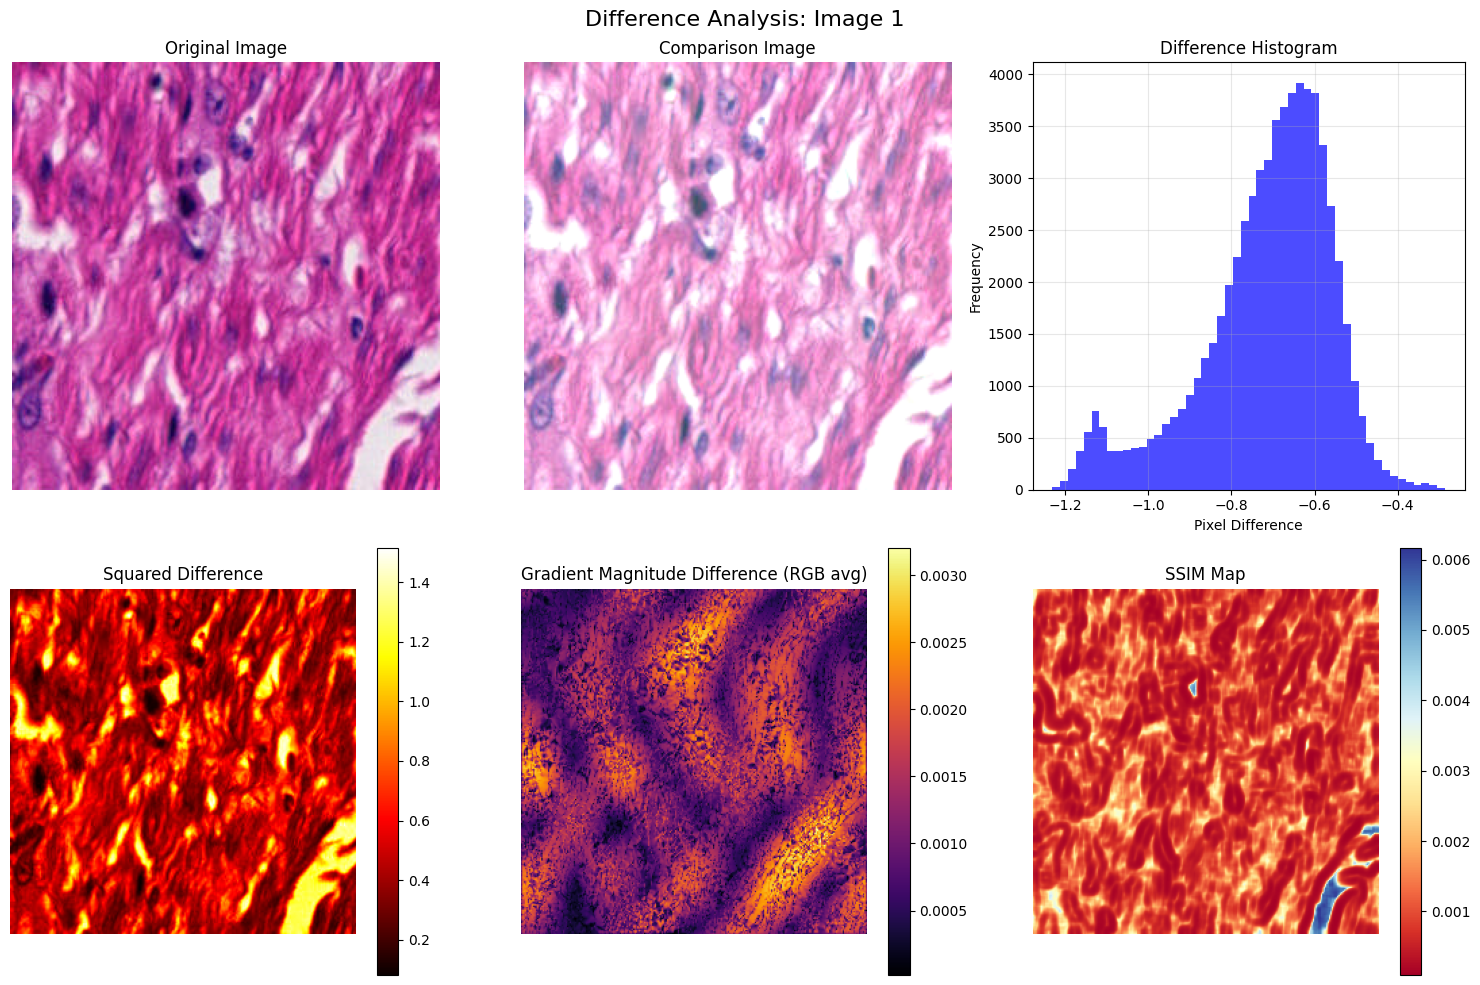

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.12781338322916697..1.3789399718715456].



Processing comparison image 2
SSIM: 0.0009


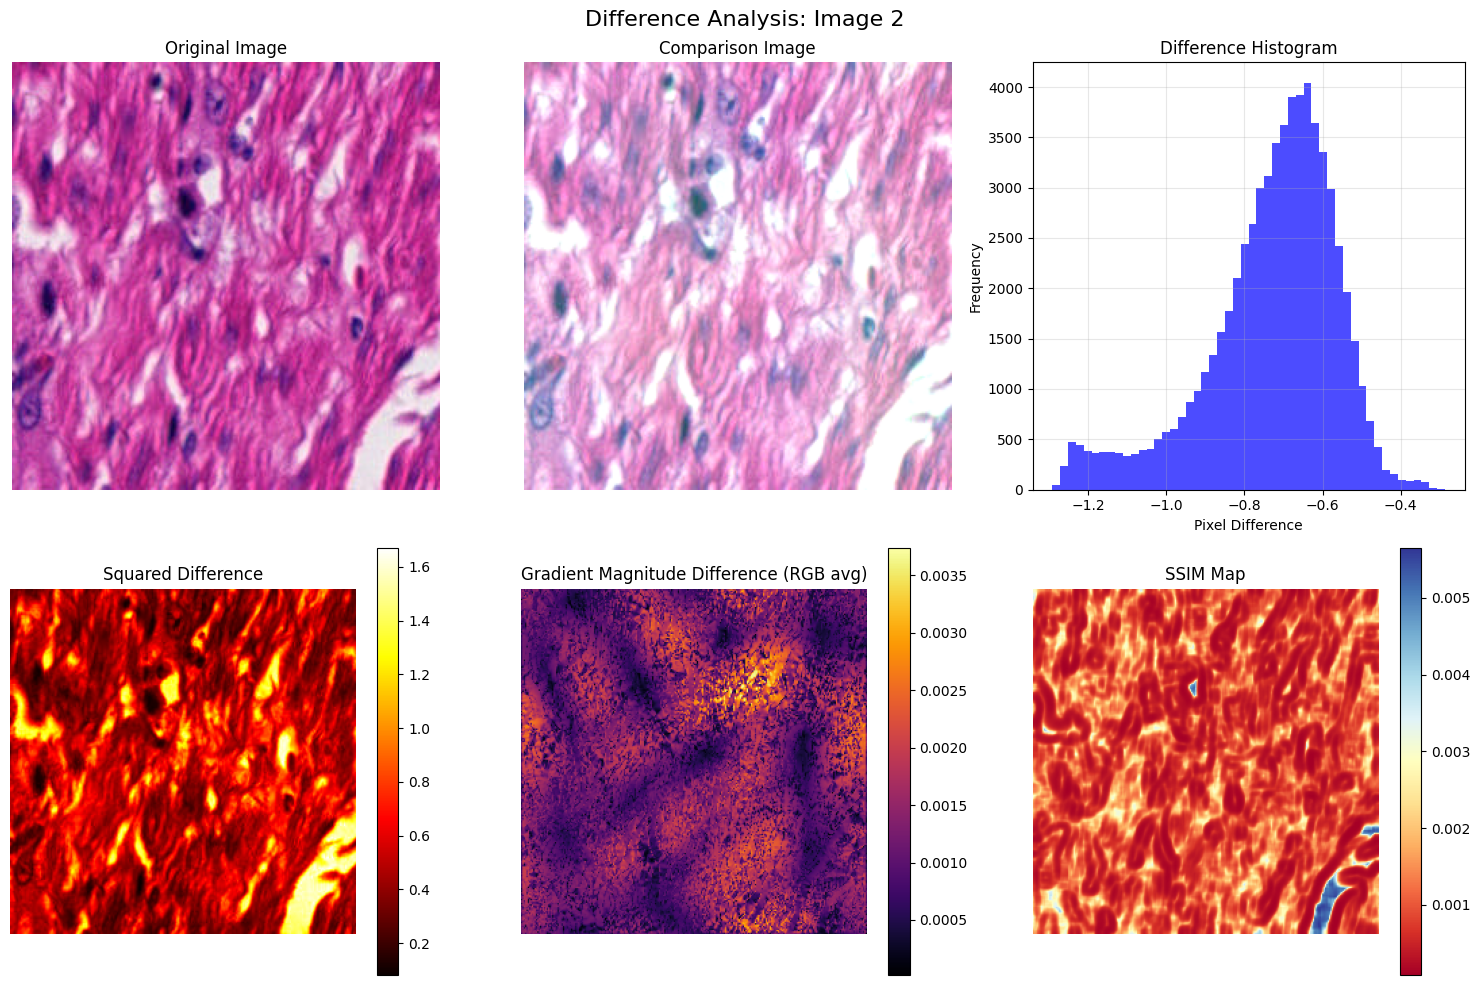

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.11320858425787321..1.292400793325143].



Processing comparison image 3
SSIM: 0.0010


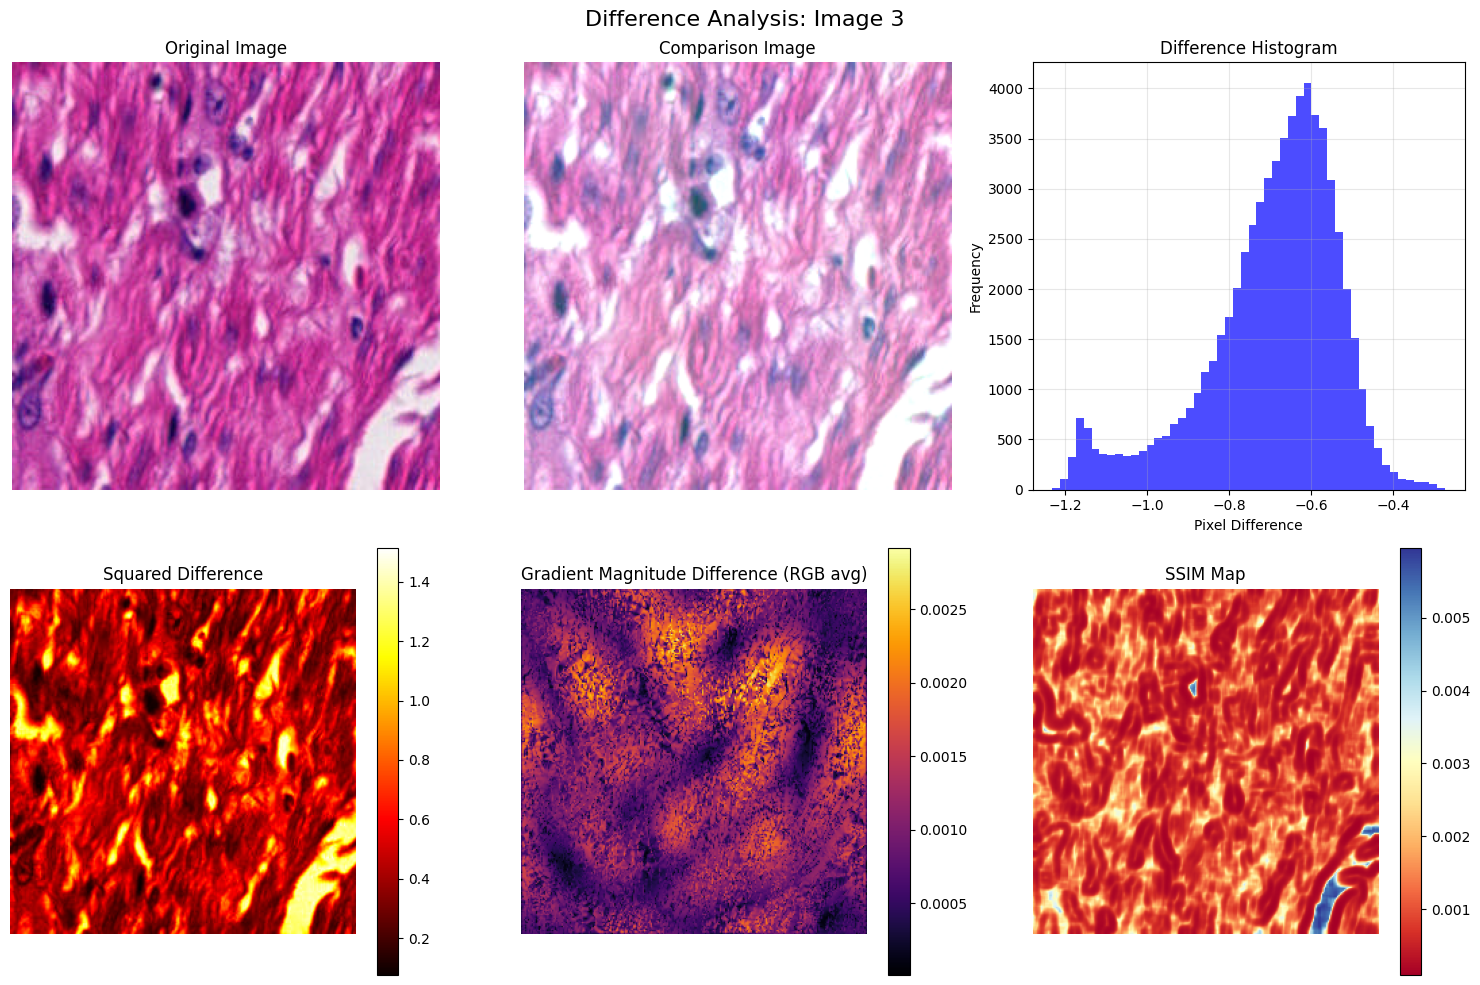

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.11215339479022088..1.2859163571225196].



Processing comparison image 4
SSIM: 0.0010


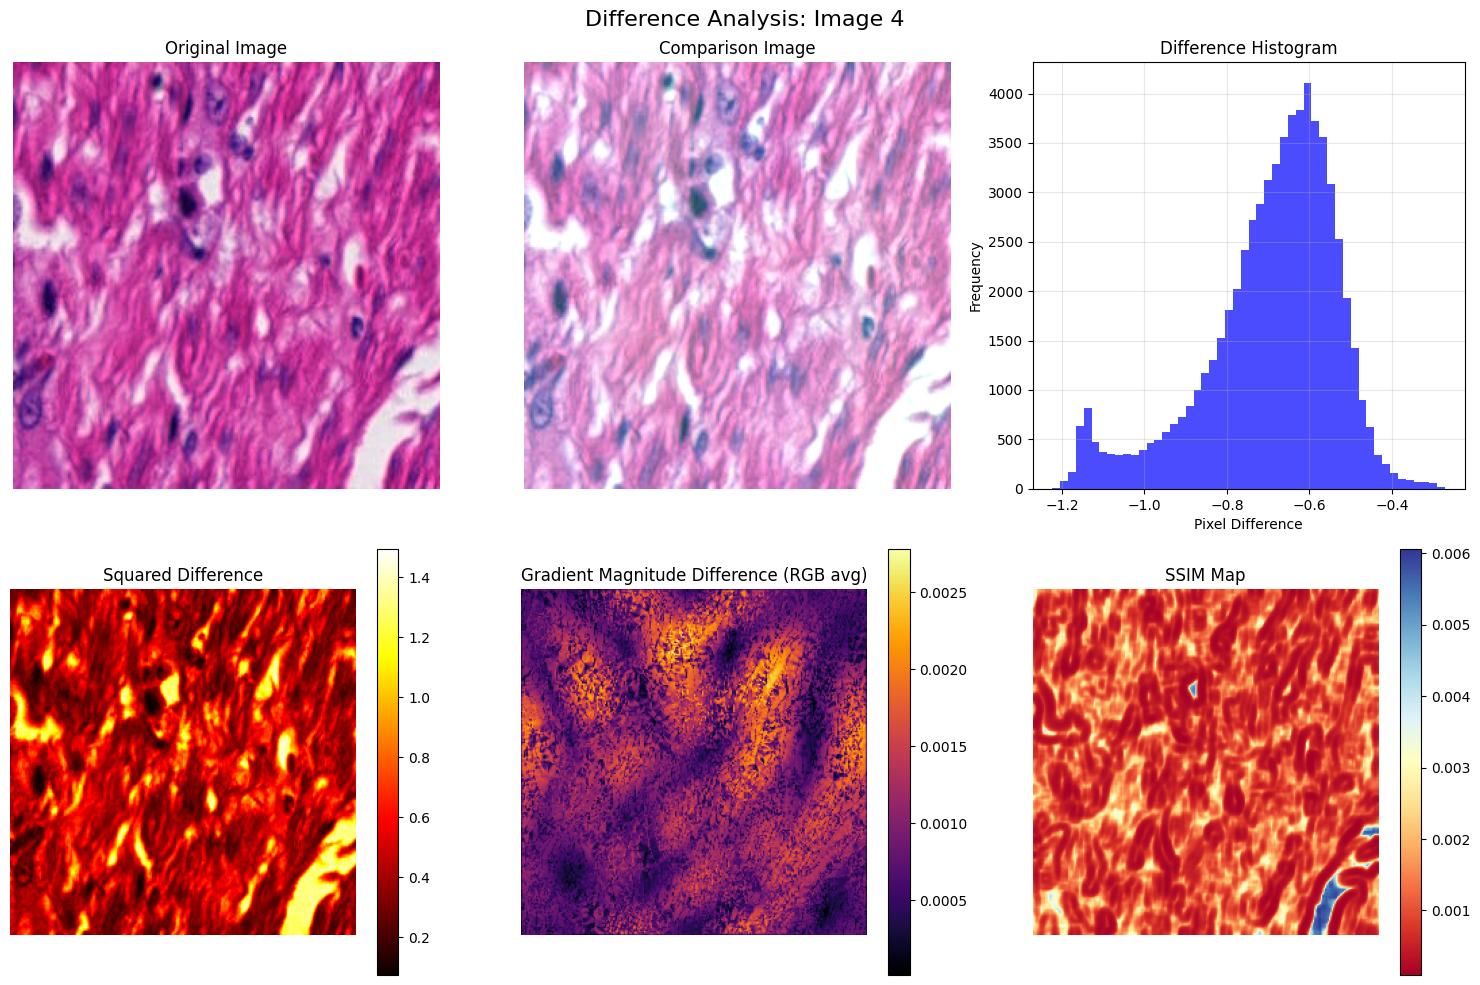

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.10707755368988824..1.196799497562515].



Processing comparison image 5
SSIM: 0.0011


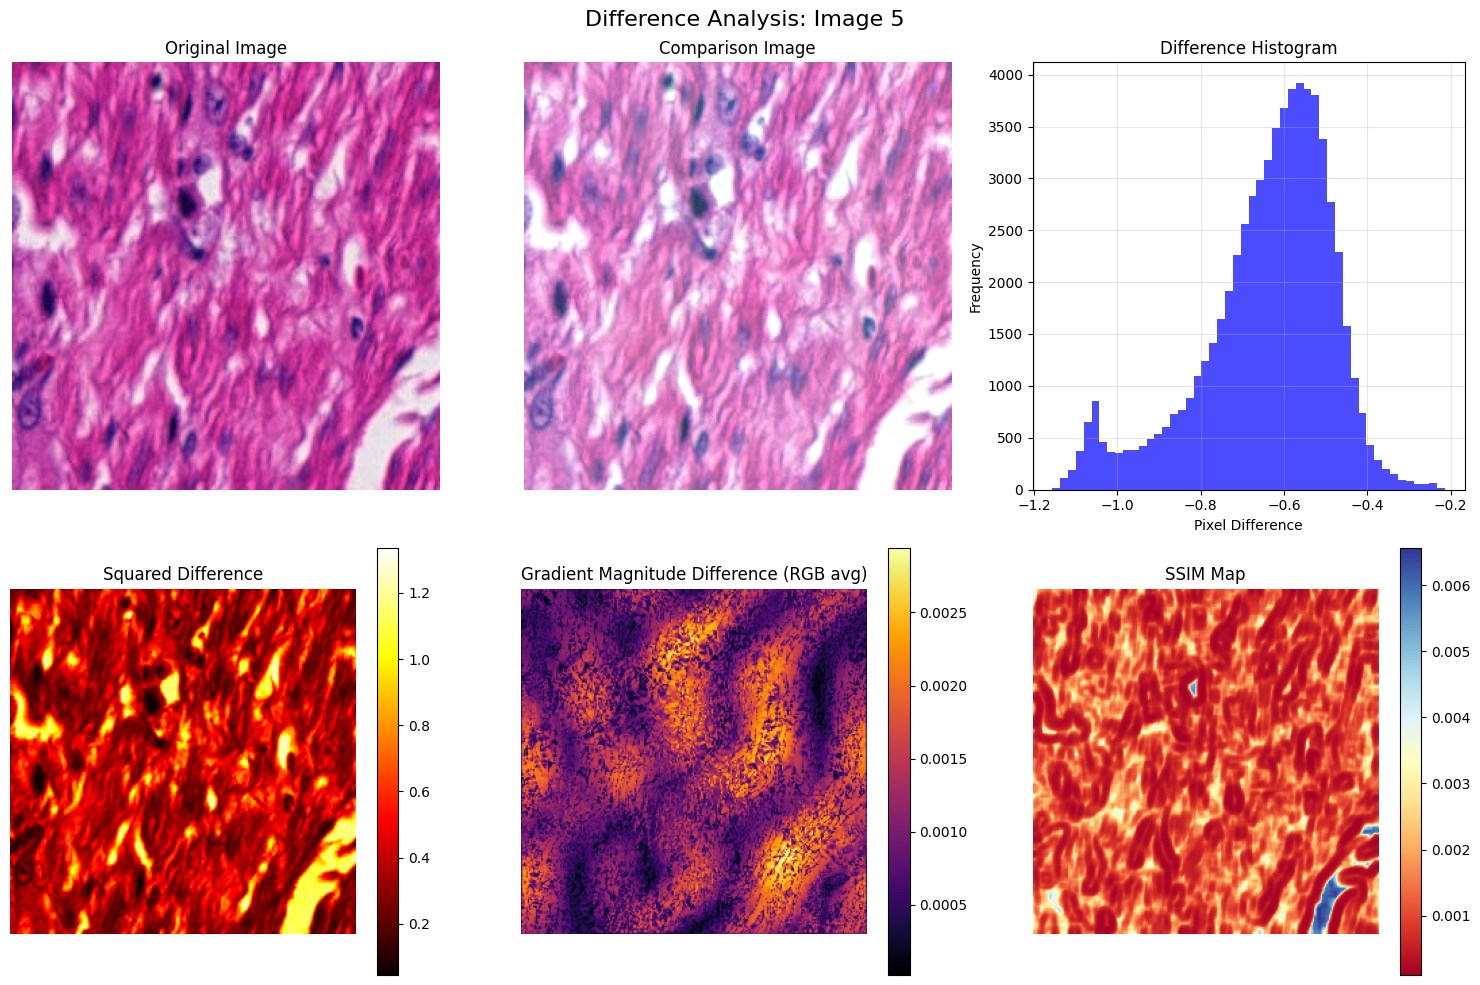

SSIM values: [0.09493298 0.09271092 0.09769848 0.09814212 0.10718567]


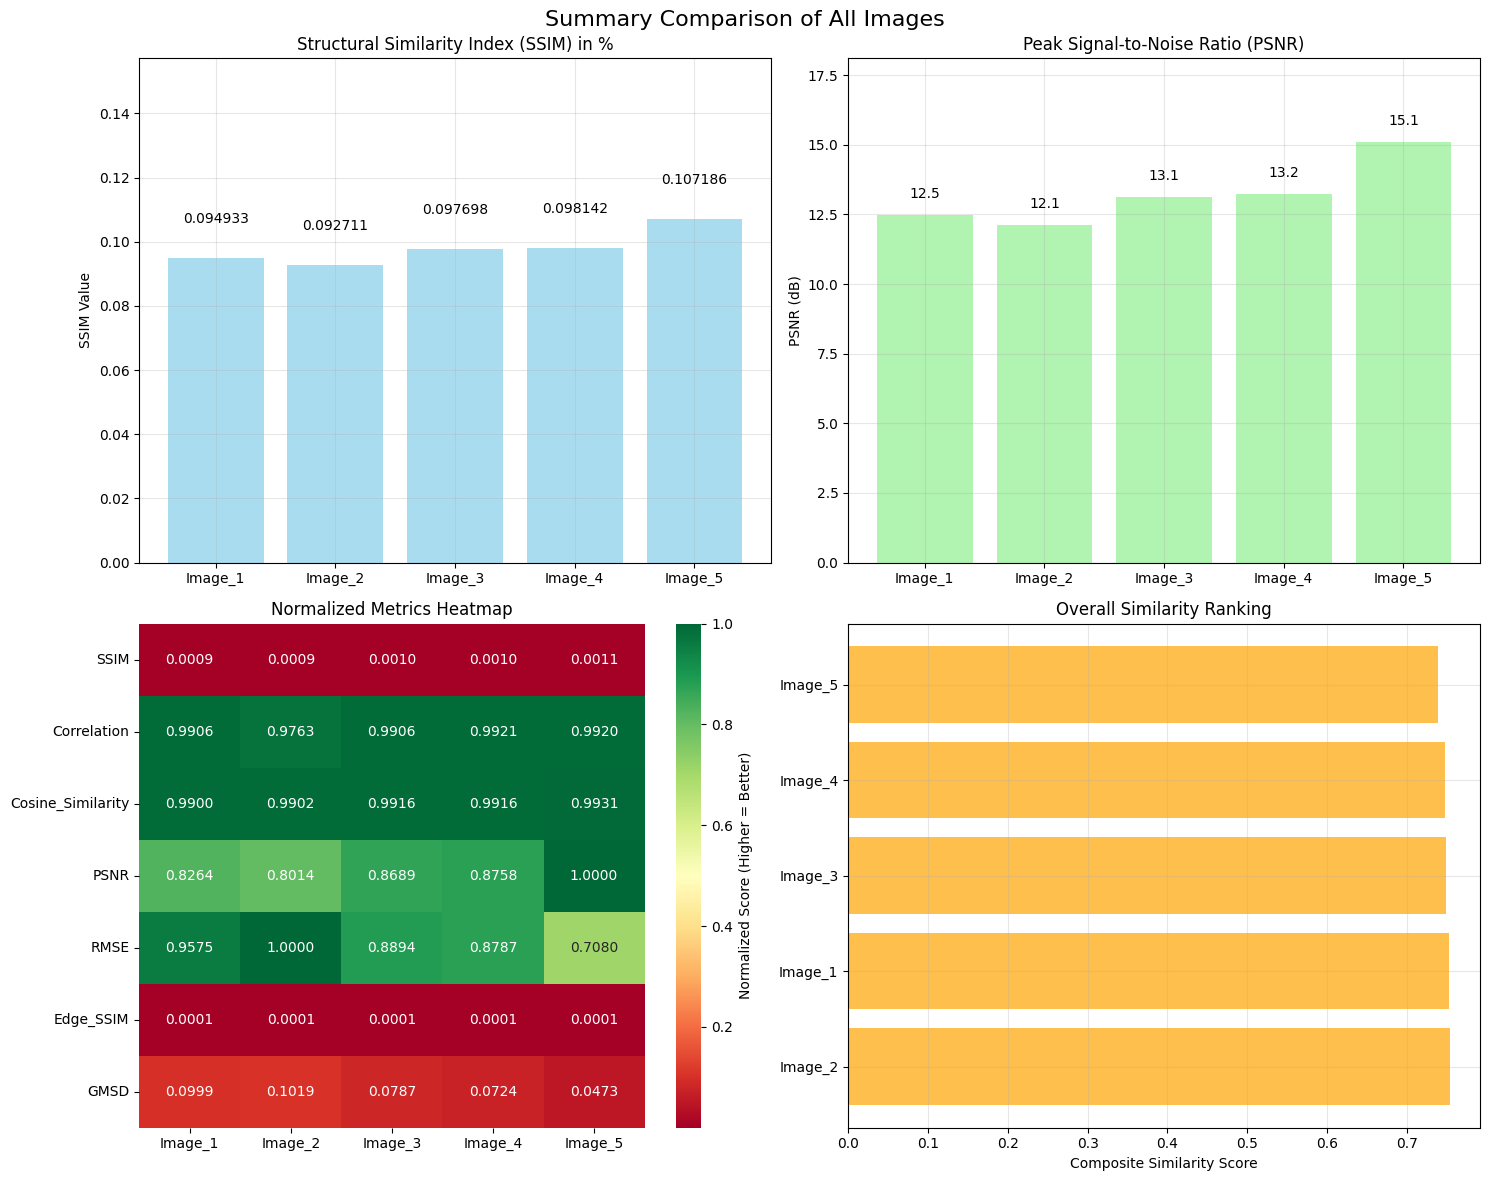


DETAILED SIMILARITY ANALYSIS RESULTS

Image_1:
----------------------------------------
Correlation:                      0.990623
Cosine Similarity:                0.990000
PSNR (Peak SNR):                  12.481769 dB
RMSE (Root Mean Squared Error):   0.237636
SSIM (Structural Similarity):     0.0009493
Edge SSIM:                        0.000062
GMSD (Gradient Magnitude Similarity Deviation): 0.099863
Histogram Intersection:           10190.000000

Image_2:
----------------------------------------
Correlation:                      0.976260
Cosine Similarity:                0.990195
PSNR (Peak SNR):                  12.104187 dB
RMSE (Root Mean Squared Error):   0.248194
SSIM (Structural Similarity):     0.0009271
Edge SSIM:                        0.000061
GMSD (Gradient Magnitude Similarity Deviation): 0.101923
Histogram Intersection:           10027.000000

Image_3:
----------------------------------------
Correlation:                      0.990628
Cosine Similarity:              

In [ ]:
# Definining variables 
dataset_path_KFbio_1 = f"/home/leolr-int/data/data/patched/dim_256/Train/Subset3_Train_1_KFBio"
KFBio_1 = deeplake.open_read_only(dataset_path_KFbio_1)

L_hyperparam = 0.01 #float(input("Enter the L hyperparameter (e.g., 0.1): "))
    
src_img = KFBio_1[200]["patch"].transpose((2, 1, 0))
KFBio_to_0 = image_to_label(src_img, 0, L_hyperparam).transpose((1, 2, 0))
KFBio_to_1 = image_to_label(src_img, 1, L_hyperparam).transpose((1, 2, 0))
KFBio_to_2 = image_to_label(src_img, 2, L_hyperparam).transpose((1, 2, 0))
KFBio_to_3 = image_to_label(src_img, 3, L_hyperparam).transpose((1, 2, 0))
KFBio_to_4 = image_to_label(src_img, 4, L_hyperparam).transpose((1, 2, 0))


results = analyze_images(src_img.transpose((1,2,0)), [KFBio_to_0, KFBio_to_1, KFBio_to_2, KFBio_to_3, KFBio_to_4], save_results=True)


